<a href="https://colab.research.google.com/github/sbovdey/ldt2023/blob/main/cash_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
#from sklearn.ensemble import RandomForestRegressor
#import lightgbm as lgb
from sklearn.metrics import mean_squared_error
#from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
#import time
import pickle
import os
from datetime import datetime
import pickle
import os

In [9]:
from google.colab import drive

In [10]:
!pip install pmdarima
import pmdarima as pm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.2 MB/s eta 0:00:00


In [11]:
mount_name = '/virt_drive'
disk_name = mount_name + '/MyDrive/Colab Notebooks'
project_name = '/ds_hack2023'
path_2_data = '/data/cash_in_terminals.csv'


In [12]:
drive.mount(mount_name)

Drive already mounted at /virt_drive; to attempt to forcibly remount, call drive.mount("/virt_drive", force_remount=True).


In [13]:
data = pd.read_csv(disk_name + project_name + path_2_data, sep=';')
data.head()

,TID,остаток на 31.08.2022 (входящий),2022-09-01 00:00:00,2022-09-02 00:00:00,2022-09-03 00:00:00,2022-09-04 00:00:00,2022-09-05 00:00:00,2022-09-06 00:00:00,2022-09-07 00:00:00,2022-09-08 00:00:00,...,2022-11-21 00:00:00,2022-11-22 00:00:00,2022-11-23 00:00:00,2022-11-24 00:00:00,2022-11-25 00:00:00,2022-11-26 00:00:00,2022-11-27 00:00:00,2022-11-28 00:00:00,2022-11-29 00:00:00,2022-11-30 00:00:00
0,406136,160000,90000,105000,99000,107000,110000,60000,75000,89000,...,91000,78000,0,165000,0,189000,106000,94000,75000,74000
1,406139,387000,103000,206000,168000,124000,78000,165000,164000,174000,...,164000,153000,151000,157000,206000,182000,123000,138000,112000,179000
2,406145,287000,143000,136000,124000,117000,123000,140000,139000,138000,...,119000,100000,179000,169000,118000,118000,114000,128000,121000,124000
3,406148,355000,50000,73000,53000,65000,75000,100000,53000,52000,...,48000,55000,65000,85000,95000,68000,62000,0,118000,70000
4,406180,597000,96000,82000,71000,72000,86000,55000,55000,75000,...,82000,56000,70000,59000,105000,70000,77000,87000,59000,55000


In [14]:
col_cash_in = 'sum_start'
data.rename(columns={'остаток на 31.08.2022 (входящий)': col_cash_in}, inplace=True)
tid_df = data[['TID', col_cash_in]].copy()
#tid_lst = list(tid_df['TID'])
tid_df.set_index('TID', inplace=True)
data.drop(columns=[col_cash_in], inplace=True)
data.head()

,TID,2022-09-01 00:00:00,2022-09-02 00:00:00,2022-09-03 00:00:00,2022-09-04 00:00:00,2022-09-05 00:00:00,2022-09-06 00:00:00,2022-09-07 00:00:00,2022-09-08 00:00:00,2022-09-09 00:00:00,...,2022-11-21 00:00:00,2022-11-22 00:00:00,2022-11-23 00:00:00,2022-11-24 00:00:00,2022-11-25 00:00:00,2022-11-26 00:00:00,2022-11-27 00:00:00,2022-11-28 00:00:00,2022-11-29 00:00:00,2022-11-30 00:00:00
0,406136,90000,105000,99000,107000,110000,60000,75000,89000,95000,...,91000,78000,0,165000,0,189000,106000,94000,75000,74000
1,406139,103000,206000,168000,124000,78000,165000,164000,174000,88000,...,164000,153000,151000,157000,206000,182000,123000,138000,112000,179000
2,406145,143000,136000,124000,117000,123000,140000,139000,138000,118000,...,119000,100000,179000,169000,118000,118000,114000,128000,121000,124000
3,406148,50000,73000,53000,65000,75000,100000,53000,52000,82000,...,48000,55000,65000,85000,95000,68000,62000,0,118000,70000
4,406180,96000,82000,71000,72000,86000,55000,55000,75000,75000,...,82000,56000,70000,59000,105000,70000,77000,87000,59000,55000


In [15]:
data = data.transpose()
data.columns = data.loc['TID'].values
data.drop(index='TID', axis=0, inplace=True)
data.index = pd.to_datetime(data.index)
data.head()

,406136,406139,406145,406148,406180,406190,406196,406504,406509,406536,...,699451,699540,699560,699572,699577,699578,699579,699629,699641,699664
2022-09-01,90000,103000,143000,50000,96000,219000,115000,382000,128000,63000,...,47000,80000,110000,124000,0,0,49000,63000,63000,0
2022-09-02,105000,206000,136000,73000,82000,236000,123000,317000,126000,65000,...,61000,102000,57000,0,25000,0,68000,63000,0,0
2022-09-03,99000,168000,124000,53000,71000,218000,121000,479000,170000,0,...,68000,140000,155000,152000,0,10000,0,63000,0,47000
2022-09-04,107000,124000,117000,65000,72000,212000,120000,333000,113000,0,...,76000,78000,192000,161000,0,0,0,64000,51000,0
2022-09-05,110000,78000,123000,75000,86000,207000,96000,232000,120000,201000,...,51000,196000,127000,53000,27000,10000,13000,74000,0,43000


In [16]:
data.index.is_monotonic_increasing, data.index.has_duplicates

(True, False)

In [17]:
len(tid_df), len(data)

(1630, 91)

In [18]:
np.min(data.values), np.max(data.values), np.sum((data == 0).values), np.sum(data.isna().values)

(0, 2697000, 8334, 0)

In [19]:
# смотрим кол-во столбцов (tid), где вообще не было 0
np.sum(np.sum((data == 0).values, axis=0) == 0)

616

In [20]:
PLOT_W = 16
PLOT_H = 2
PVAL_MAX = .05 # for stationarity definition and for selections AR lags
LAGS_MAX = 14 # for ACF/PACF analysis
#PVAL_MIN = .1 
D_TEST = 30

# 1. Выводы.
- Всего предоставлены монотонные ежедневные данные за три месяца (91 день) о 1630 терминалах. 
- Отрицательных приростов нет
- Пропусков нет
- 0-вые приросты встречаются достаточно часто - 8334 раза, только примерно в трети точках не было нулевых приростов. Как было подчеркнуто на встрече, 0-вые приросты это только 0-приросты, а не сведения о состоявшемся обслуживании (этот тезис подтверждается наличием 616 точек без 0 в течение всего периода отложенной выборки).
-   
- Где-то когда-то прирост в 2,7 ляма - это круто

# 2. Анализ.

In [78]:
path_2_results = '/results'
path_2_models_results = path_2_results + '/models_results'

In [82]:
def check_stationarity(series): # Проверяем стационарность Эд-Фуллером
    result = adfuller(series.values)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'      {key: >3}: {value:.3f}')
    print()
    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("Time series is stationary")
    else:
        print("Time series is non-stationary")
    return result

def show_acf_pacf(data, max_lags=LAGS_MAX, ax=None): # Смотрим ACF/PACF
    if ax is None:
        f, ax = plt.subplots(nrows=2, ncols=1, figsize=(PLOT_W, 2*PLOT_H + 1))
    plot_acf(data, lags=list(range(1, max_lags+1)), ax=ax[0])
    plot_pacf(data, lags=list(range(1, max_lags+1)), ax=ax[1], method='ywm') # 'ywm' make PACF in [-1,1]
    #plt.tight_layout()
    plt.show()
    
def plot_ts(col_lst, df=data, max_curves=3): # Рисуем любое кол-во ts (rare)
    rows = (len(col_lst) - 1) // max_curves + 1
    if rows > 1:
        fig, axs = plt.subplots(nrows=rows, ncols=1, figsize=(PLOT_W, rows * (PLOT_H + 1.5)))
        for i in range(rows):
            df[col_lst[i * max_curves : (i + 1) * max_curves]].plot(ax=axs[i])
    else:
        ax = df[col_lst].plot(figsize=(PLOT_W, PLOT_H))

# Показываем конкретный ds: собственно ts, все его производные до стационарности, PACF/ACF стационарного ряда
def show_ts(tid, df=data, tid_df=tid_df, max_lags=14):
    #col_ranks = [f'is_stationary_d{i}' for i in range(max_rank + 1)]
    curr_rank = tid_df.loc[tid, 'rank']
    fig, axs = plt.subplots(nrows=curr_rank + 3, ncols=1, figsize=(PLOT_W, (curr_rank + 3) * (PLOT_H + 1)))
    curve_to_diff = df[tid].copy()
    curve_to_diff.plot(ax=axs[0], grid=True)
    axs[0].set_title(f'Прирост наличности в терминале {tid}', fontsize=10) 
    axs[0].tick_params(axis='x', labelsize=0)
    for i in range(1, curr_rank + 1):
        curve_to_diff = curve_to_diff.diff().dropna()
        curve_to_diff.plot(ax=axs[i], grid=True)
        axs[i].set_title(f'{i}-производная прироста наличности в терминале {tid}', fontsize=10)
        axs[i].tick_params(axis='x', labelsize=0)
    show_acf_pacf(df[tid].values, max_lags=max_lags, ax=axs[-2:])
    return

def csv_dump(df, fn='some_df', suff='_last'):
    path = disk_name + project_name + path_2_models_results
    fn = f'{path}/{fn}{suff}.csv'
    df.to_csv(fn)
    #print(fn)
    return pd.DataFrame()

In [22]:
stationary = [] # разделим все терминалы по степени интегрированности
is_non_stationary = True
rank = 0
tid_to_process = tid_df.index.to_list()

while tid_to_process:
    for col in tid_to_process: # ADF-test для ...
        ts = data[col].copy() # данных или ...
        for _ in range(rank): # для соотв. разностей
            ts = ts.diff().dropna()
        result = adfuller(ts.values)
        tid_df.loc[col, f'd{rank}_pval_ADFtest'] = result[1]

    tid_df.loc[tid_df[f'd{rank}_pval_ADFtest'] < PVAL_MAX, 'rank'] = rank

    stationary.append(list(tid_df[ (tid_df['rank'] == rank )].index))
    tid_to_process = list(tid_df[tid_df['rank'].isna()].index)
    rank += 1

tid_df['rank'] = tid_df['rank'].astype('int')

In [23]:
[ (i, len(lst)) for i, lst in enumerate(stationary)]

[(0, 1311), (1, 315), (2, 4)]

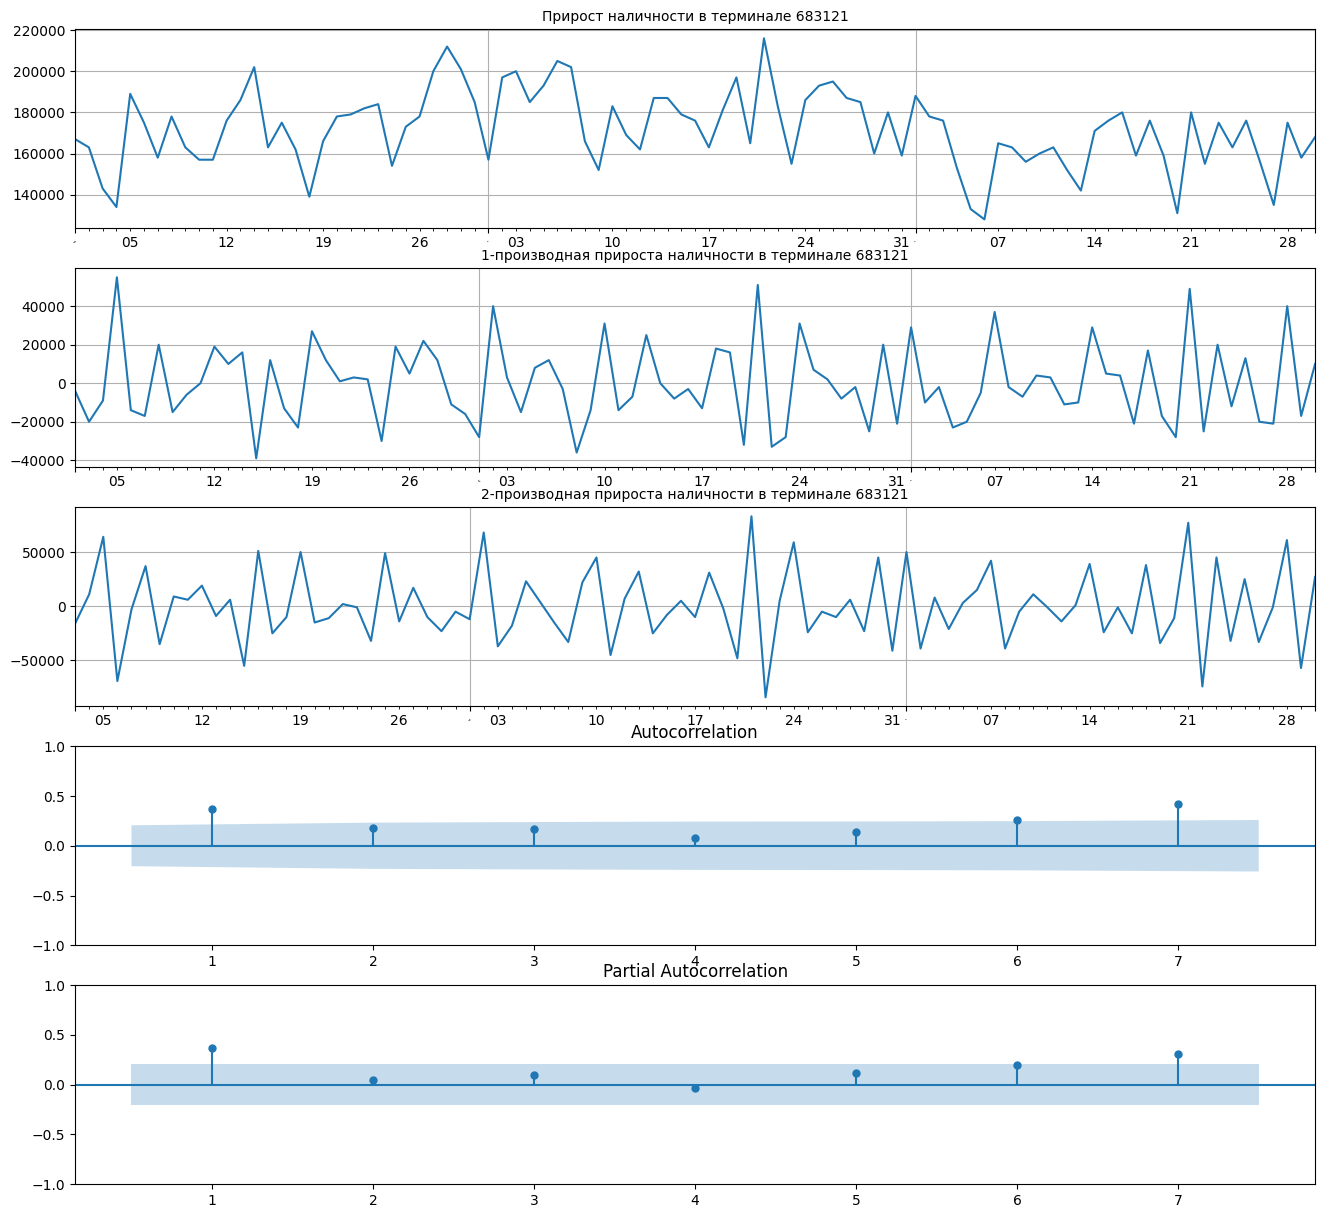

In [57]:
tid = stationary[2][2]
show_ts(tid, max_lags=7)

In [25]:
for tid in tid_df.index:
    mean_ts = data[:-D_TEST][tid].mean()
    tid_df.loc[tid, 'mean_train'] = mean_ts
    tid_df.loc[tid, 'sigma_train'] = data[:-D_TEST][tid].var() ** .5
    tid_df.loc[tid, 'max_outlier'] = data[tid].max() - mean_ts

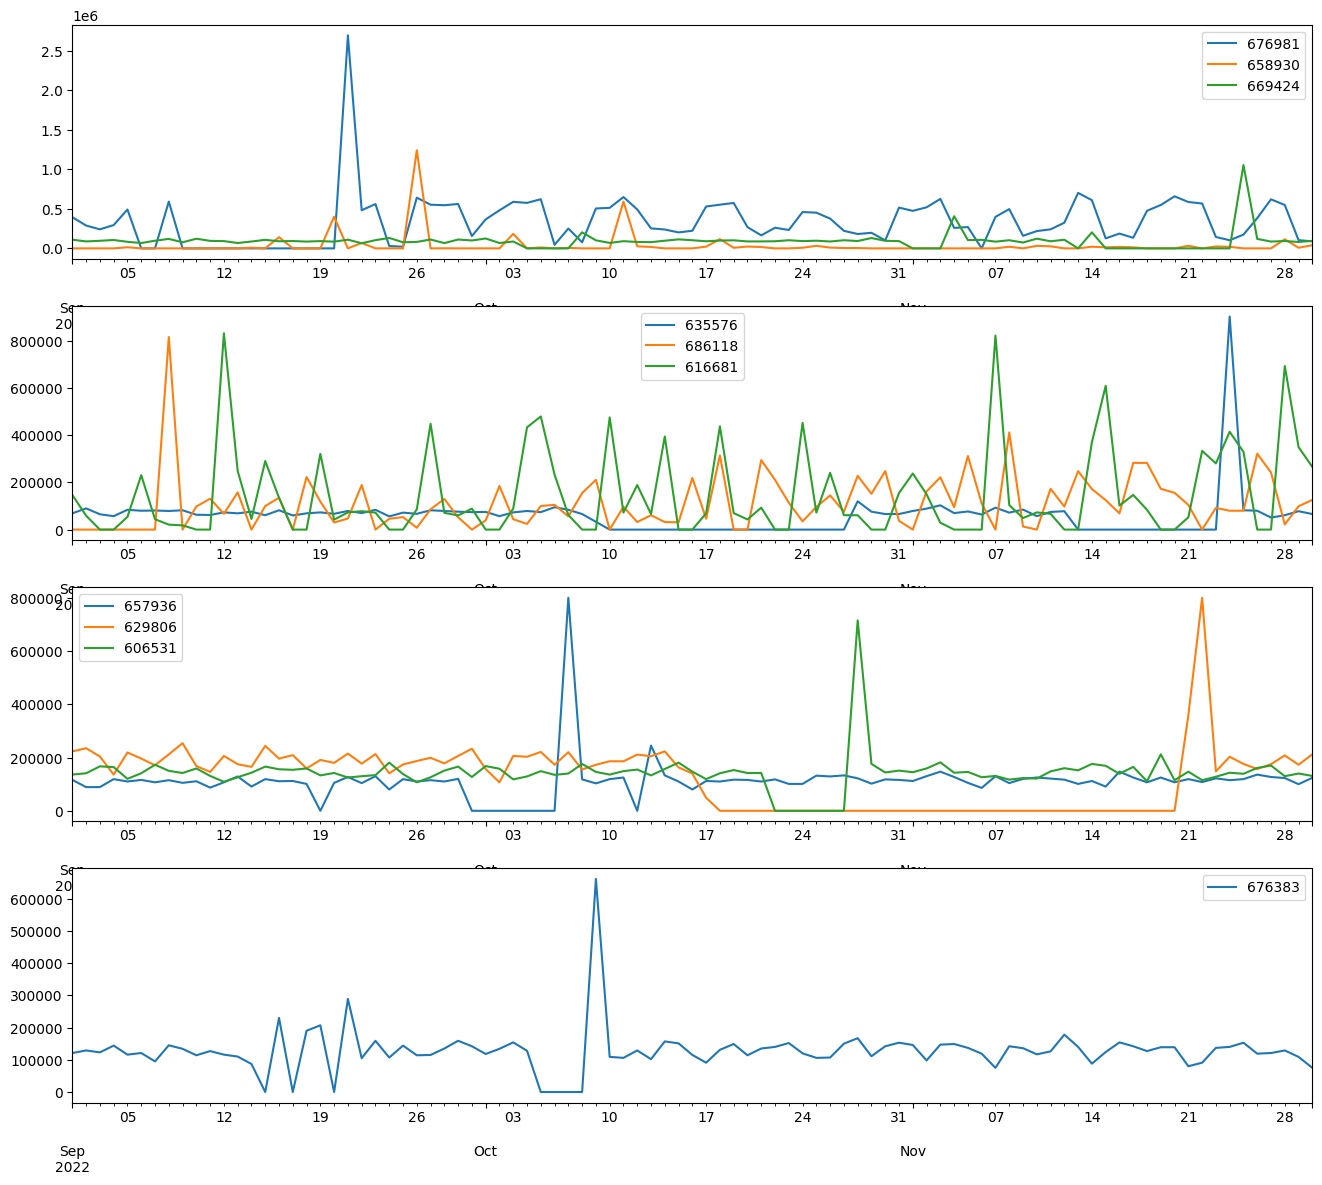

In [26]:
tid_max_outlier = tid_df.sort_values(by='max_outlier', ascending=False).head(10).index
plot_ts(tid_max_outlier)

In [27]:
tid_out_3sigma = tid_df[tid_df.max_outlier > tid_df.mean_train + 3 * tid_df.sigma_train].sort_values(by='max_outlier', ascending=False).index

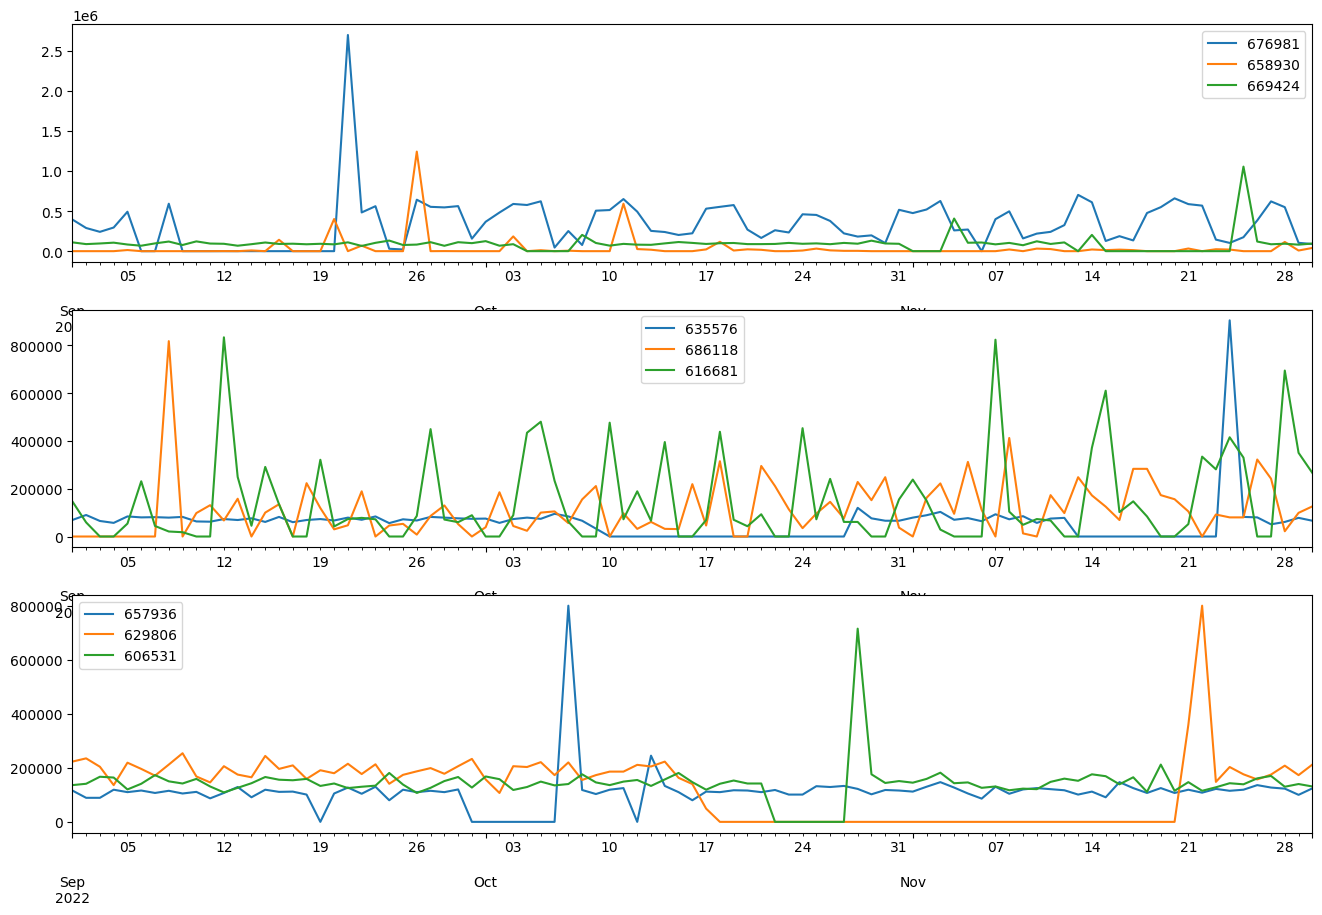

In [28]:
plot_ts(tid_out_3sigma[:9])

#####Проверим выбросы по абсолютному размеру

In [58]:
# Отдельно посмотрим статистики по outliers - создадим бинарные стольбцы, 
# указывающие на разные наличие выброса в каждую дату для каждого tid
data_exp = data.copy()
def add_outliers(abs_tresh=500_000, sigma_thres=1):
    for tid in tid_df.index:
        mean_ts, sigma_ts = tid_df.loc[tid, 'mean_train'], tid_df.loc[tid, 'sigma_train']
        condition = (data_exp[tid] > abs_tresh) & (data_exp[tid] > mean_ts + sigma_thres * sigma_ts)
        data_exp[f'{tid}_outl_abs_{abs_tresh}_sigma_{sigma_thres}'] = np.where(condition, 1, 0)

In [ ]:
add_outliers()
add_outliers(500_000, 2)
add_outliers(300_000, 1)
add_outliers(200_000, 2)

In [ ]:
add_outliers(500_000, 0)

In [64]:
cols = [col.split('_')[:6] for col in data_exp.columns if 'abs' in str(col)]
param_outl = {(col[3], col[5]) for col in cols}
for tid in tid_df.index:
    for params in param_outl:
        col_2_sum = f'{tid}_outl_abs_{params[0]}_sigma_{params[1]}'
        tid_df.loc[tid, f'total_outl_abs_{params[0]}_sg*{params[1]}'] = data_exp[col_2_sum].sum()
        #print(col_2_sum)
#sigma_mult = {col[5] for col in cols}
#param_outl

In [65]:
cols_in_tid_df = [col for col in tid_df.columns if 'abs' in col]

In [66]:
tid_df[cols_in_tid_df].describe()

,total_outl_abs_500000_sg*1,total_outl_abs_500000_sg*2,total_outl_abs_300000_sg*1,total_outl_abs_200000_sg*2,total_outl_abs_500000_sg*0
count,1630.000000,1630.000000,1630.000000,1630.000000,1630.000000
mean,0.025153,0.017178,0.102454,0.241718,0.067485
std,0.365794,0.184612,0.781889,0.819035,1.287084
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000
max,10.000000,4.000000,17.000000,11.000000,34.000000


In [67]:
tid_df[tid_df['total_outl_abs_500000_sg*0'] > 0].describe()

,sum_start,d0_pval_ADFtest,rank,d1_pval_ADFtest,d2_pval_ADFtest,mean_train,sigma_train,max_outlier,total_outl_abs_500000_sg*1,total_outl_abs_500000_sg*2,total_outl_abs_300000_sg*1,total_outl_abs_200000_sg*2,total_outl_abs_500000_sg*0
count,1.900000e+01,1.900000e+01,19.000000,3.000000e+00,0.0,19.000000,19.000000,1.900000e+01,19.000000,19.000000,19.000000,19.000000,19.000000
mean,4.173158e+05,5.902727e-02,0.157895,6.326602e-07,NaN,177290.767903,103571.630550,6.793408e+05,2.157895,1.473684,3.473684,2.526316,5.789474
std,3.703866e+05,1.678472e-01,0.374634,1.088873e-06,NaN,183345.501607,83532.593302,4.734802e+05,2.692854,0.904828,4.247462,2.435123,10.721624
min,0.000000e+00,1.325968e-21,0.000000,2.598627e-19,NaN,44278.688525,20463.789157,2.540000e+05,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.475000e+05,1.609975e-16,0.000000,4.003400e-09,NaN,83180.327869,62474.187639,4.459672e+05,1.000000,1.000000,1.000000,1.000000,1.000000
50%,3.410000e+05,2.577426e-11,0.000000,8.006800e-09,NaN,112688.524590,85644.946323,5.329672e+05,1.000000,1.000000,2.000000,2.000000,1.000000
75%,5.865000e+05,1.240507e-07,0.000000,9.489903e-07,NaN,170827.868852,112932.532626,7.135410e+05,1.500000,1.500000,4.000000,3.000000,2.000000
max,1.517000e+06,6.778129e-01,1.000000,1.889974e-06,NaN,789245.901639,382226.878811,2.373475e+06,10.000000,4.000000,17.000000,11.000000,34.000000


In [68]:
tid_df[tid_df['total_outl_abs_300000_sg*1'] > 0].describe()

,sum_start,d0_pval_ADFtest,rank,d1_pval_ADFtest,d2_pval_ADFtest,mean_train,sigma_train,max_outlier,total_outl_abs_500000_sg*1,total_outl_abs_500000_sg*2,total_outl_abs_300000_sg*1,total_outl_abs_200000_sg*2,total_outl_abs_500000_sg*0
count,7.100000e+01,7.100000e+01,71.000000,1.600000e+01,0.0,71.000000,71.000000,7.100000e+01,71.000000,71.000000,71.000000,71.000000,71.000000
mean,3.747183e+05,6.288338e-02,0.225352,2.087475e-03,NaN,126847.379358,64862.274724,3.811385e+05,0.577465,0.394366,2.352113,2.281690,1.549296
std,2.742221e+05,1.505443e-01,0.420788,6.478349e-03,NaN,109189.781419,52266.254812,3.068394e+05,1.670432,0.801407,2.976568,1.928605,6.018516
min,0.000000e+00,0.000000e+00,0.000000,2.598627e-19,NaN,14344.262295,4830.062960,1.433607e+05,0.000000,0.000000,1.000000,1.000000,0.000000
25%,1.470000e+05,1.630066e-16,0.000000,2.934501e-10,NaN,71360.655738,37605.467183,2.356721e+05,0.000000,0.000000,1.000000,1.000000,0.000000
50%,3.240000e+05,9.045167e-10,0.000000,8.876634e-08,NaN,101721.311475,55360.191651,2.977213e+05,0.000000,0.000000,1.000000,1.000000,0.000000
75%,5.675000e+05,1.761292e-02,0.000000,2.093067e-04,NaN,144286.885246,77933.397344,4.031639e+05,1.000000,1.000000,2.000000,3.000000,1.000000
max,1.517000e+06,7.157596e-01,1.000000,2.601380e-02,NaN,789245.901639,382226.878811,2.373475e+06,10.000000,4.000000,17.000000,11.000000,34.000000


In [69]:
tid_df[tid_df['total_outl_abs_200000_sg*2'] > 0].describe()

,sum_start,d0_pval_ADFtest,rank,d1_pval_ADFtest,d2_pval_ADFtest,mean_train,sigma_train,max_outlier,total_outl_abs_500000_sg*1,total_outl_abs_500000_sg*2,total_outl_abs_300000_sg*1,total_outl_abs_200000_sg*2,total_outl_abs_500000_sg*0
count,2.110000e+02,2.110000e+02,211.000000,4.800000e+01,1.000000e+00,211.000000,211.000000,2.110000e+02,211.000000,211.000000,211.000000,211.000000,211.000000
mean,3.796256e+05,8.890186e-02,0.232227,3.332327e-03,5.875694e-20,110733.198664,44451.673105,2.195606e+05,0.194313,0.132701,0.791469,1.867299,0.521327
std,2.582039e+05,2.040757e-01,0.434362,1.214613e-02,NaN,72538.075916,35718.264748,2.147827e+05,1.002457,0.498972,2.048024,1.467561,3.551428
min,0.000000e+00,0.000000e+00,0.000000,2.768053e-26,5.875694e-20,14344.262295,4830.062960,3.921311e+04,0.000000,0.000000,0.000000,1.000000,0.000000
25%,1.580000e+05,1.733244e-16,0.000000,2.084482e-12,5.875694e-20,71196.721311,24626.151772,1.277705e+05,0.000000,0.000000,0.000000,1.000000,0.000000
50%,3.270000e+05,1.008040e-10,0.000000,1.032947e-08,5.875694e-20,97901.639344,37326.055594,1.704426e+05,0.000000,0.000000,0.000000,1.000000,0.000000
75%,5.870000e+05,2.499965e-02,0.000000,3.103247e-05,5.875694e-20,133557.377049,55195.200967,2.412705e+05,0.000000,0.000000,1.000000,2.000000,0.000000
max,1.517000e+06,9.556653e-01,2.000000,7.207304e-02,5.875694e-20,789245.901639,382226.878811,2.373475e+06,10.000000,4.000000,17.000000,11.000000,34.000000


In [70]:
tids_gr500K = tid_df[tid_df['total_outl_abs_500000_sg*1'] > 0].index.tolist()

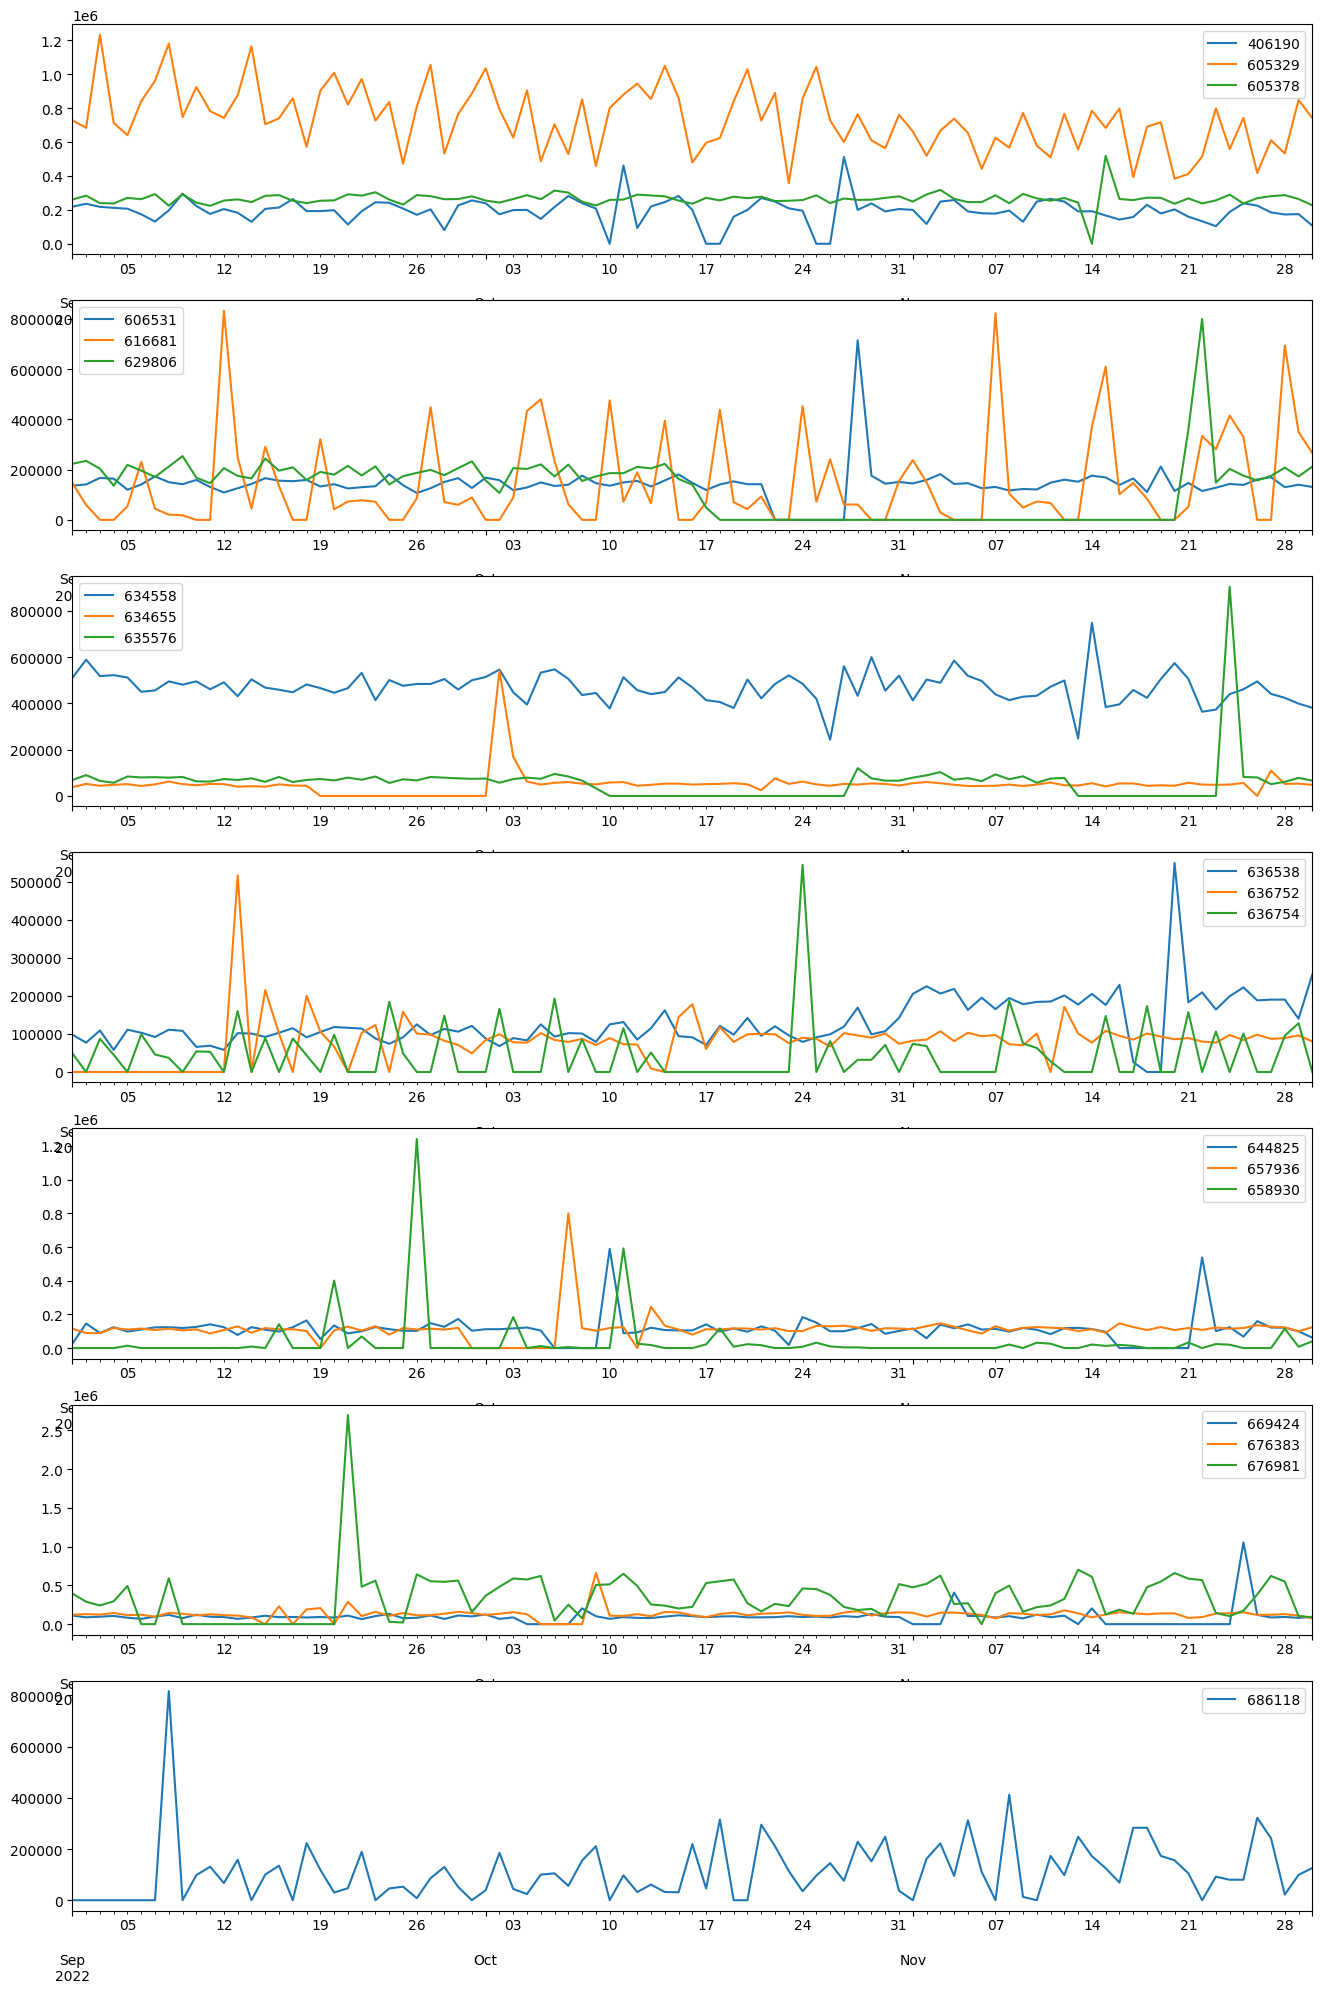

In [71]:
plot_ts(tids_gr500K)

In [83]:
# csv_dump(data_exp, fn='outliers_and_data_per_tid_per_date', suff='')

""


##### Гипотеза: 
После изучения графиков для самых больших выбросов во временных рядах возникла след. гипотезы - ненормальные пики связаны с 0-выми приростами в предыдущие дни.

Проверим для всех tid, в которых максимальный выброс превышает Среднее по train периоду плюс 3 Сигмы

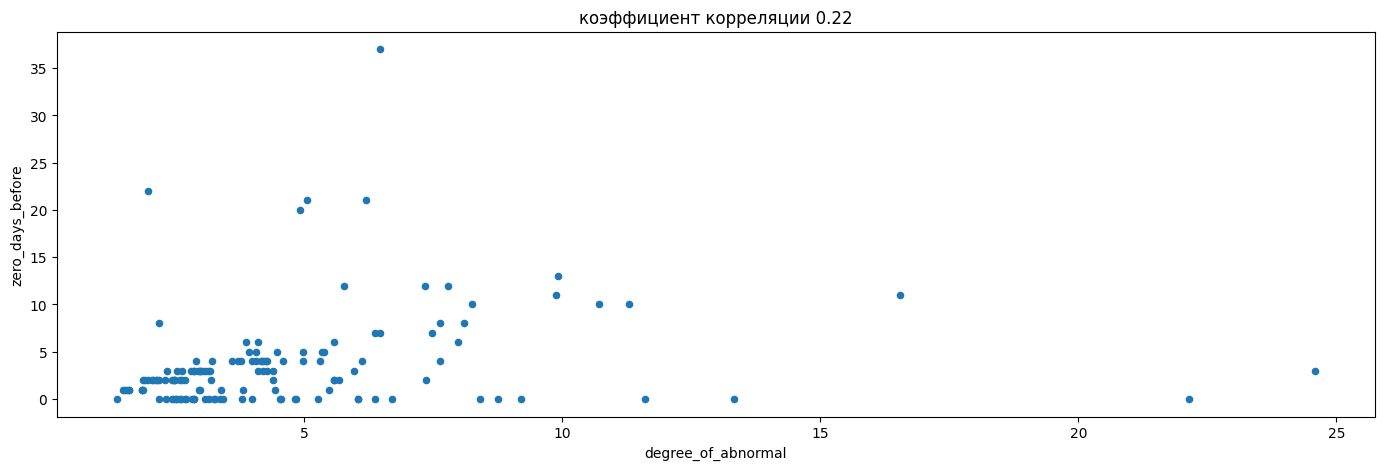

In [29]:
count_abnormal = pd.DataFrame()
for tid in tid_out_3sigma:
    count_abnormal.loc[tid, 'degree_of_abnormal'] = tid_df.loc[tid, 'max_outlier'] / tid_df.loc[tid, 'mean_train'] 
    index_max = data[tid].idxmax()
    loc = data.index.get_loc(index_max)
    day_shift = 1
    while data.iloc[loc - day_shift, :][tid] < 100:
        day_shift += 1
    count_abnormal.loc[tid, 'zero_days_before'] = day_shift - 1
ax = count_abnormal.plot(x='degree_of_abnormal', y='zero_days_before', kind='scatter', figsize=(17,5), title=f'коэффициент корреляции {count_abnormal.corr().iloc[0,1]:.2f}')

In [30]:
#tid_super_abnormal = count_abnormal[count_abnormal.zero_days_before == 0].index
super_abnormal_df = count_abnormal[count_abnormal.zero_days_before == 0].sort_values(by='degree_of_abnormal', ascending=False)
super_abnormal_df.head()

,degree_of_abnormal,zero_days_before
606043,22.145143,0.0
699578,13.324853,0.0
699577,11.591743,0.0
680614,9.200000,0.0
680612,8.760000,0.0


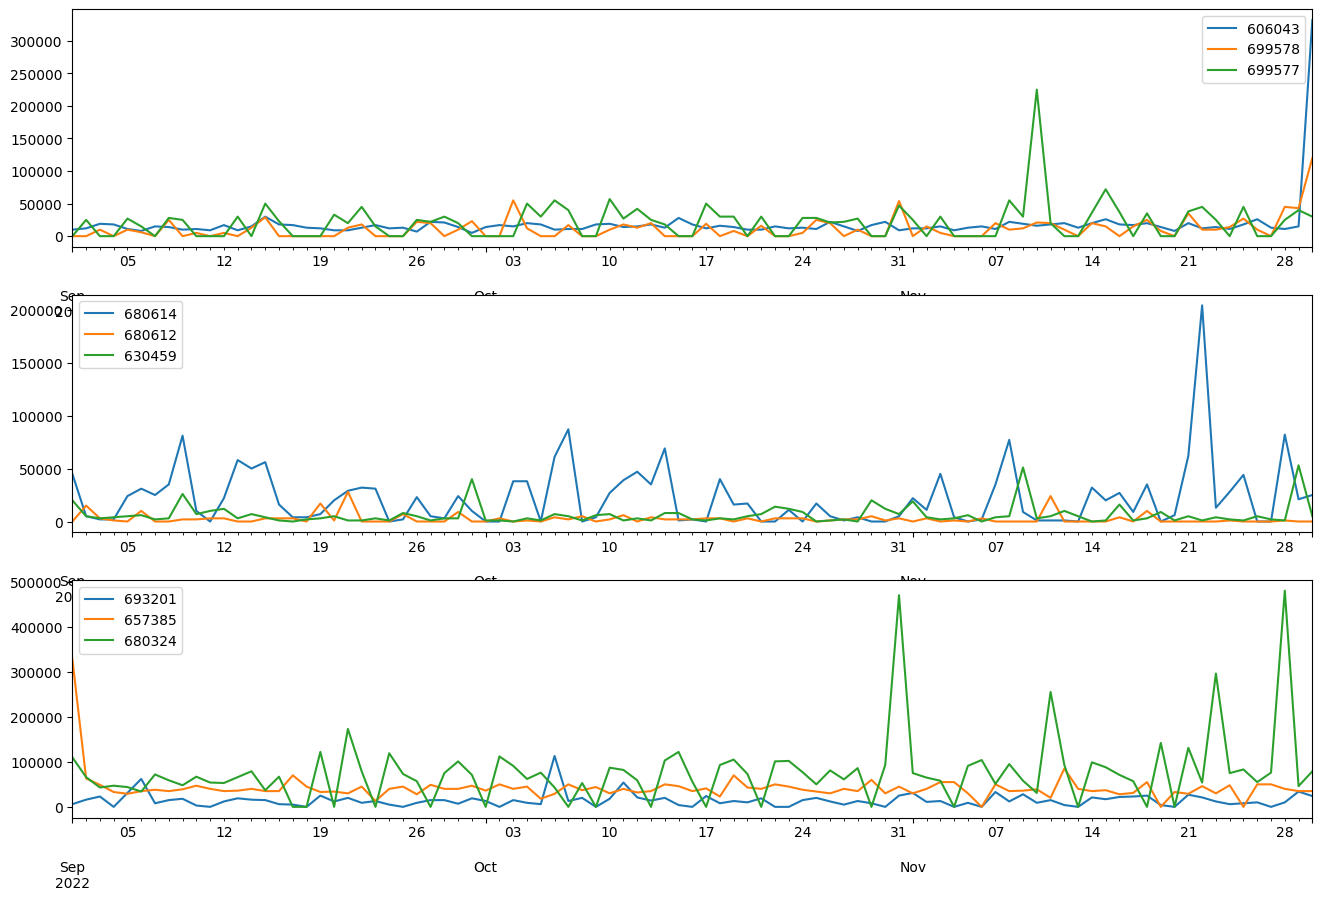

In [31]:
plot_ts(super_abnormal_df[:9].index)

In [32]:
tid_super_abnormal = [606043]
print(data[data[tid_super_abnormal[0]] < 100].index)
tid_df.loc[tid_super_abnormal[0]]

DatetimeIndex([], dtype='datetime64[ns]', freq=None)


sum_start           48000.000000
d0_pval_ADFtest         0.715760
rank                    1.000000
d1_pval_ADFtest         0.026014
d2_pval_ADFtest              NaN
mean_train          14344.262295
sigma_train          4830.062960
max_outlier        317655.737705
Name: 606043, dtype: float64

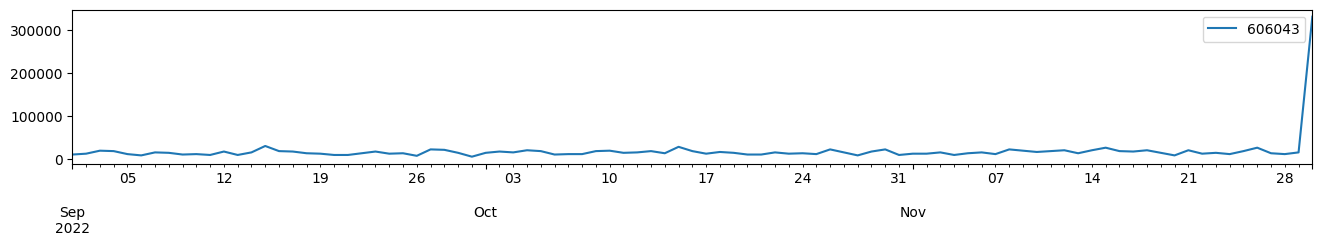

In [33]:
plot_ts(tid_super_abnormal[0:1])

In [34]:
tid_df.loc[super_abnormal_df.index].describe()

,sum_start,d0_pval_ADFtest,rank,d1_pval_ADFtest,d2_pval_ADFtest,mean_train,sigma_train,max_outlier
count,37.000000,3.700000e+01,37.000000,5.000000e+00,0.0,37.000000,37.000000,37.000000
mean,220567.567568,4.954905e-02,0.135135,8.434464e-03,NaN,29911.829863,17943.101585,130142.224191
std,164047.171492,1.474167e-01,0.346583,1.206353e-02,NaN,29388.373738,18992.712666,139802.683469
min,0.000000,0.000000e+00,0.000000,1.380248e-22,NaN,2868.852459,4027.161877,19688.524590
25%,93000.000000,9.402828e-17,0.000000,1.055808e-10,NaN,10327.868852,6165.566288,34836.065574
50%,165000.000000,1.684878e-13,0.000000,3.872208e-10,NaN,17836.065574,9975.133016,64934.426230
75%,327000.000000,8.608191e-06,0.000000,1.615852e-02,NaN,38885.245902,19565.666371,174426.229508
max,661000.000000,7.157596e-01,1.000000,2.601380e-02,NaN,144098.360656,85644.946323,655901.639344


In [35]:
tid_super_abnormal.append( tid_df.loc[super_abnormal_df.index]['max_outlier'].idxmax() )

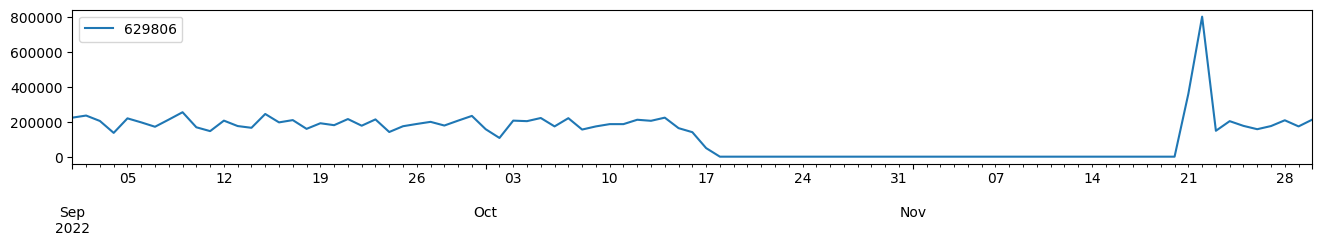

In [36]:
plot_ts(tid_super_abnormal[1:])

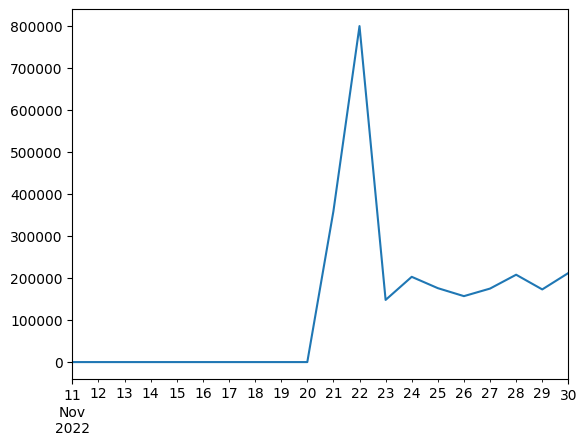

In [37]:
ax=data[tid_super_abnormal[1]][-20:].plot()

In [38]:
data[tid_super_abnormal[1]][-12:-7]

2022-11-19         0
2022-11-20         0
2022-11-21    359000
2022-11-22    800000
2022-11-23    148000
Name: 629806, dtype: int64

### Гипотеза 2
- График выше демонстрирует, что выброс может длиться несколько дней (в примере 2-дневное строго линейное нарастание приростов наличности!). 
- Посмотрим, как связана вероятность выброса не с кол-вом нулевых дней, обязательно предшествующих выборсу, а с долей нудевых дней в заранее заданном окне.

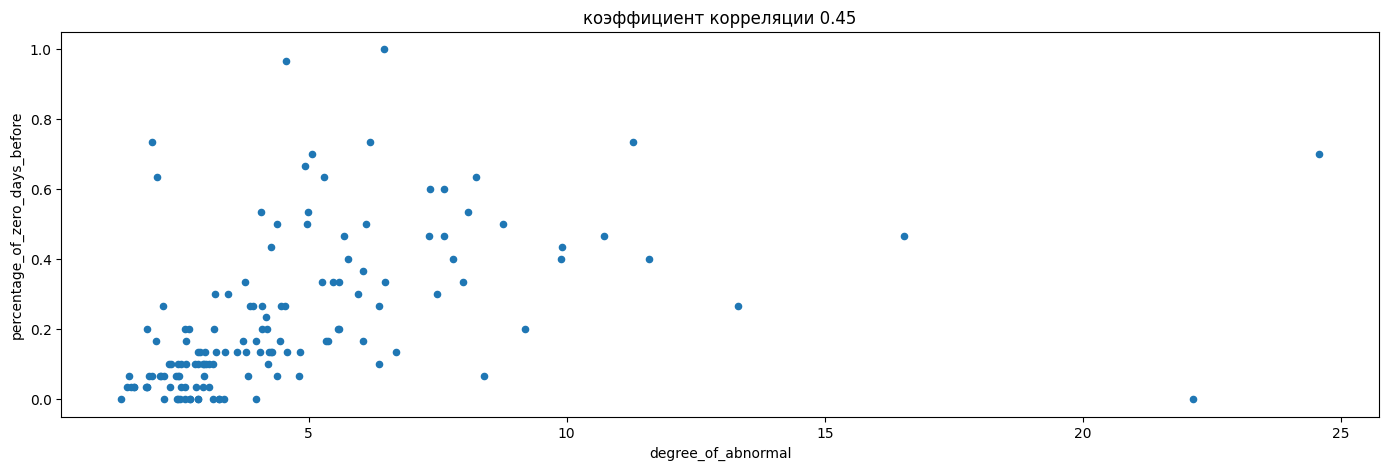

In [39]:
count_abnormal_2 = pd.DataFrame()
zero_window = 30
for tid in tid_out_3sigma:
    count_abnormal_2.loc[tid, 'degree_of_abnormal'] = tid_df.loc[tid, 'max_outlier'] / tid_df.loc[tid, 'mean_train'] 
    index_max = data[tid].idxmax()
    loc = data.index.get_loc(index_max)
    count_zero = 0
    for day_shift in range(1, zero_window + 1):
        if data.iloc[loc - day_shift, :][tid] < 100:
            count_zero += 1
    count_abnormal_2.loc[tid, 'percentage_of_zero_days_before'] = count_zero / zero_window
ax = count_abnormal_2.plot(x='degree_of_abnormal', y='percentage_of_zero_days_before', kind='scatter', figsize=(17,5), title=f'коэффициент корреляции {count_abnormal_2.corr().iloc[0,1]:.2f}')

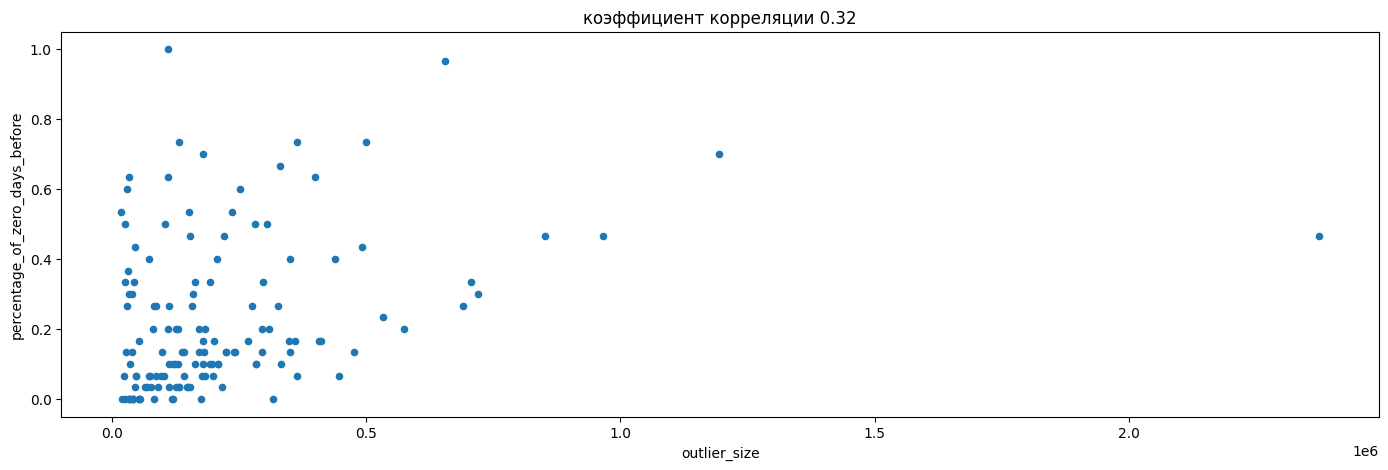

In [40]:
count_abnormal_2 = pd.DataFrame()
zero_window = 30
for tid in tid_out_3sigma:
    count_abnormal_2.loc[tid, 'outlier_size'] = tid_df.loc[tid, 'max_outlier'] 
    index_max = data[tid].idxmax()
    loc = data.index.get_loc(index_max)
    count_zero = 0
    for day_shift in range(1, zero_window + 1):
        if data.iloc[loc - day_shift, :][tid] < 100:
            count_zero += 1
    count_abnormal_2.loc[tid, 'percentage_of_zero_days_before'] = count_zero / zero_window
ax = count_abnormal_2.plot(x='outlier_size', y='percentage_of_zero_days_before', kind='scatter', figsize=(17,5), title=f'коэффициент корреляции {count_abnormal_2.corr().iloc[0,1]:.2f}')

Гипотеза 3
-Проверим просто абсолютные значения выбросов и насколько это 


# 3. Моделирование.

In [41]:
def show_predictions(compare_df, ds_name='', max_lags=LAGS_MAX, title='test'):
    y_true = compare_df['fact']
    y_hat = compare_df['predict']  
    show_acf = (title != 'test')
    nrows = 2 + show_acf * 2
    fig, axs = plt.subplots(nrows=nrows, ncols=1, figsize=(PLOT_W, nrows * (PLOT_H + 1.5)))
    compare_df.plot(ax=axs[0])
    axs[0].set_title(f'RMSE on {ds_name} {title} set: {mean_squared_error(y_true, y_hat) ** 0.5: .2f}')
    resid = y_true - y_hat
    resid.plot(ax=axs[1])
    result = sm.stats.diagnostic.acorr_ljungbox(resid - np.mean(resid), lags=max_lags, return_df=True)
    axs[1].set_title(f'График остатков, Среднее: {np.mean(resid): .2f} Тест Льюинга-Бокса после обнуления среднего до {max_lags}го лага мин={min(result.lb_pvalue): .6f}, макс={max(result.lb_pvalue): .6f}')
    if show_acf:
        show_acf_pacf(resid, ax=axs[2:], max_lags=max_lags)

def show_predictions_full(compare_df_full, ds_name='', days_for_test=D_TEST, show_train=False):
    show_predictions(compare_df_full[-days_for_test:], ds_name=ds_name)
    if show_train:
        show_predictions(compare_df_full[:-days_for_test], ds_name=ds_name, title='train')

def fit_sarima(ts, order=(0,0,0), seasonal_order=(0, 0, 0, 0)):
    model = ARIMA(ts, order=order, seasonal_order=seasonal_order, freq='1D')
    return model.fit()

def show_predictions_sarima(ts, days_for_test=D_TEST, order=(0,0,0), seasonal_order=(0, 0, 0, 0), show_train=False):
    train = ts[:-days_for_test].copy()
    test =  ts[-days_for_test:].copy()
    model_fitted = fit_sarima(train, order=order, seasonal_order=seasonal_order)
    compare_df = pd.DataFrame(ts)
    compare_df.columns = ['fact']
    
    compare_df['predict'] = model_fitted.predict(start=ts.index[0], end=ts.index[-1])
    
    show_predictions_full(compare_df, ds_name=train.name, days_for_test=days_for_test, show_train=show_train)
    return model_fitted

def show_predictions_autoarima_fitted(model_fitted, ts_full, days_for_test=D_TEST, show_train=False):
    compare_df = pd.DataFrame(ts_full)
    compare_df.columns = ['fact']

    prediction = model_fitted.predict(n_periods=days_for_test)
    predict_in_sample = model_fitted.predict_in_sample()
    compare_df.loc[prediction.index, 'predict'] = prediction
    compare_df.loc[predict_in_sample.index, 'predict'] = predict_in_sample

    show_predictions_full(compare_df, ds_name=ts_full.name, days_for_test=days_for_test, show_train=show_train)

def show_predictions_autoarima(ts, days_for_test=D_TEST, season_order=7, show_train=False):
    model_fitted = pm.auto_arima(ts[:-days_for_test].copy(), seasonal=True, m=season_order)
    show_predictions_autoarima_fitted(model_fitted, ts, days_for_test=D_TEST, show_train=show_train)
    return model_fitted

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


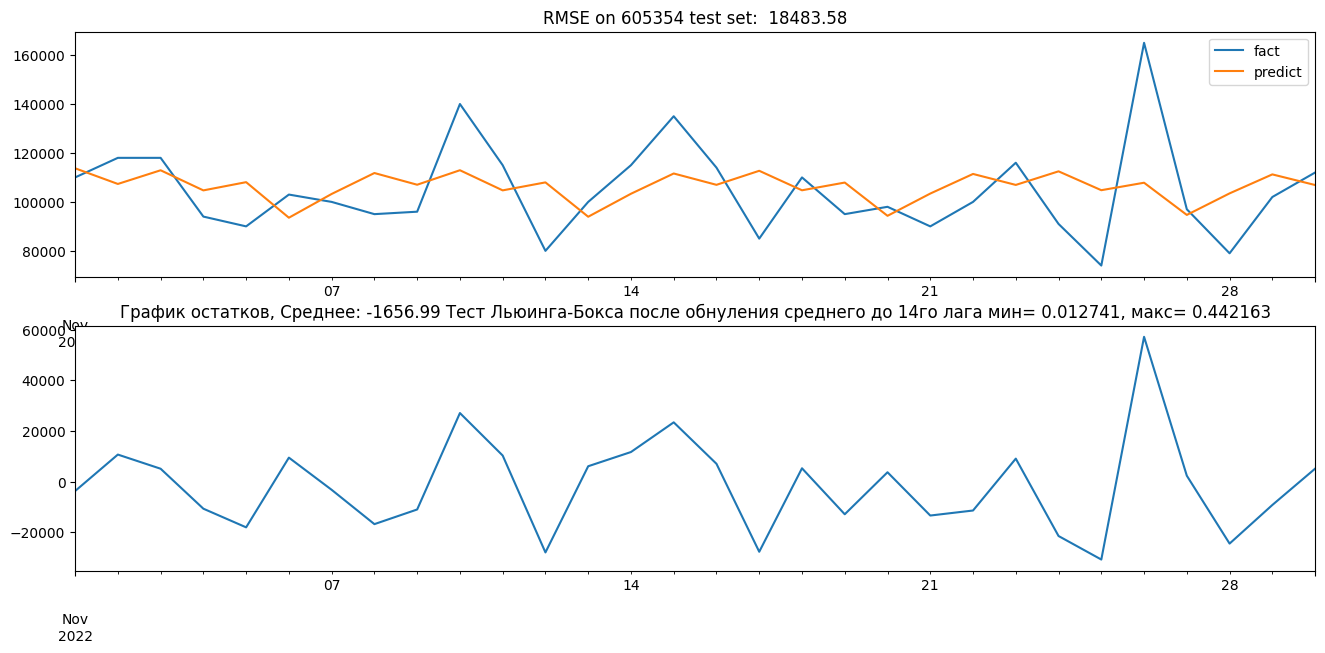

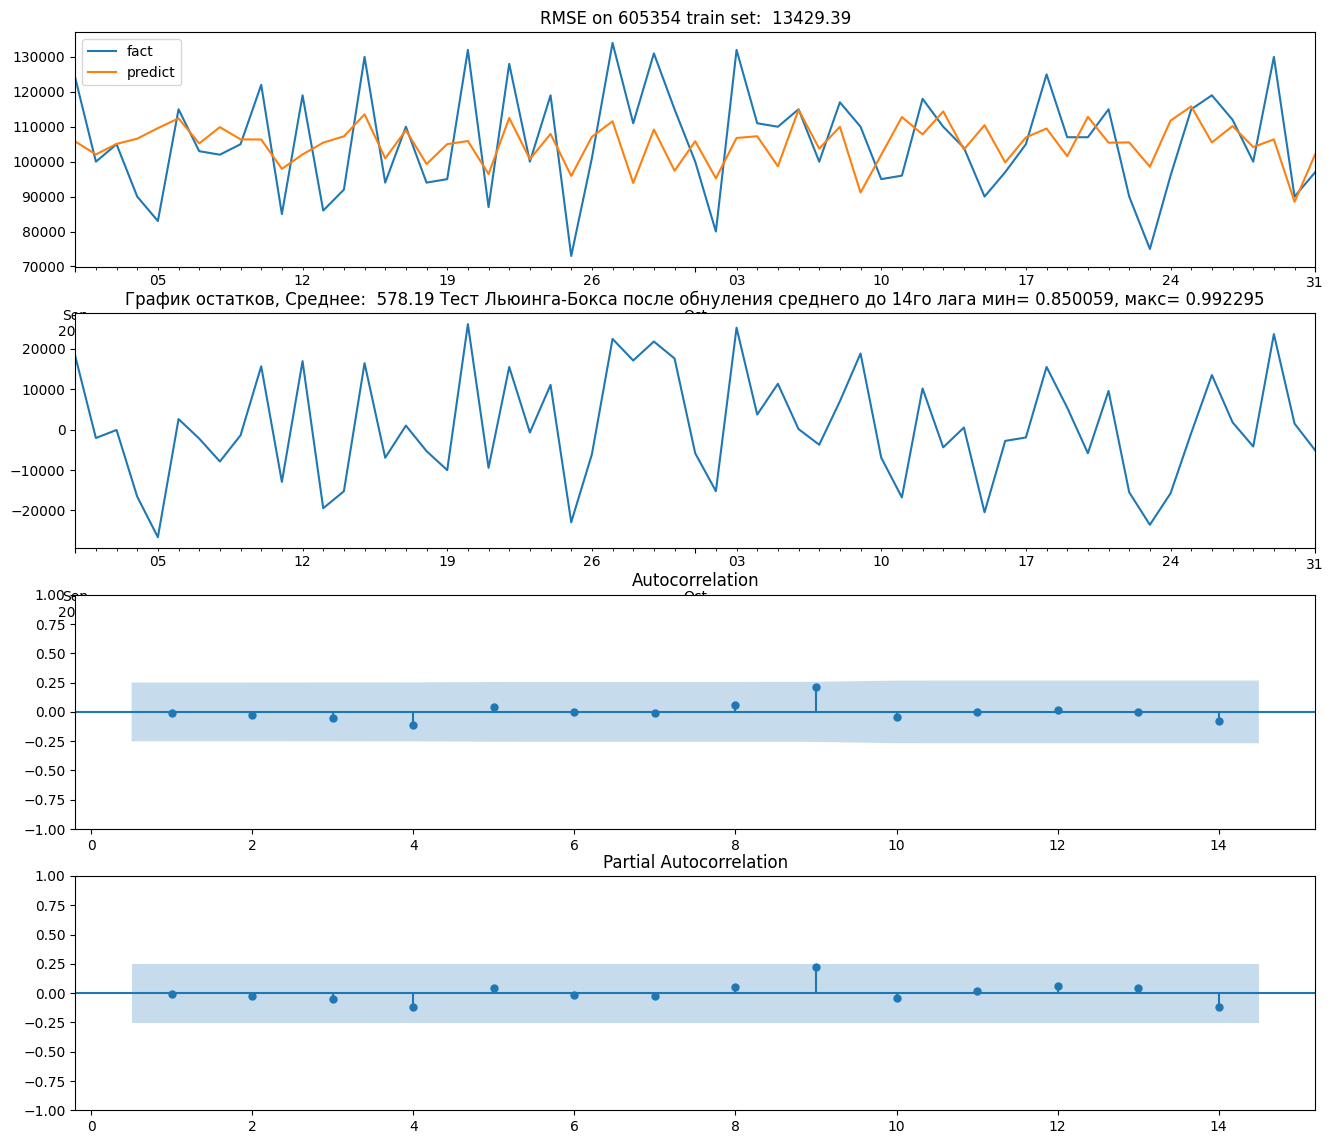

In [43]:
models_h = {}
tid_modeling = 605354
models_h[tid_modeling] = {}
models_h[tid_modeling]['arima_h'] = show_predictions_sarima(data[tid_modeling], order=(2, 0, 0), seasonal_order=(1, 0, 1, 7), show_train=True)

In [44]:
models_h[tid_modeling]['arima_h'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                            605354   No. Observations:                   61
Model:             ARIMA(2, 0, 0)x(1, 0, [1], 7)   Log Likelihood                -667.077
Date:                           Thu, 25 May 2023   AIC                           1346.154
Time:                                   04:23:06   BIC                           1358.819
Sample:                               09-01-2022   HQIC                          1351.118
                                    - 10-31-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.058e+05   3167.987     33.392      0.000    9.96e+04    1.12e+05
ar.L1         -0.2264      0.175     -1.291      0.197      -0.570       0.117
ar.L2         -0.1091      0.169     -0.644      0.520      -0.441       0.223
ar.S.L7        0.9681      0.137      7.046      0.000       0.699       1.237
ma.S.L7       -0.8555      0.341     -2.512      0.012      -1.523      -0.188
sigma2      2.142e+08      0.016   1.34e+10      0.000    2.14e+08    2.14e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.87
Prob(Q):                              0.98   Prob(JB):                         0.39
Heteroskedasticity (H):               0.82   Skew:                             0.09
Prob(H) (two-sided):                  0.65   Kurtosis:                         2.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.33e+26. Standard errors may be unstable.
"""

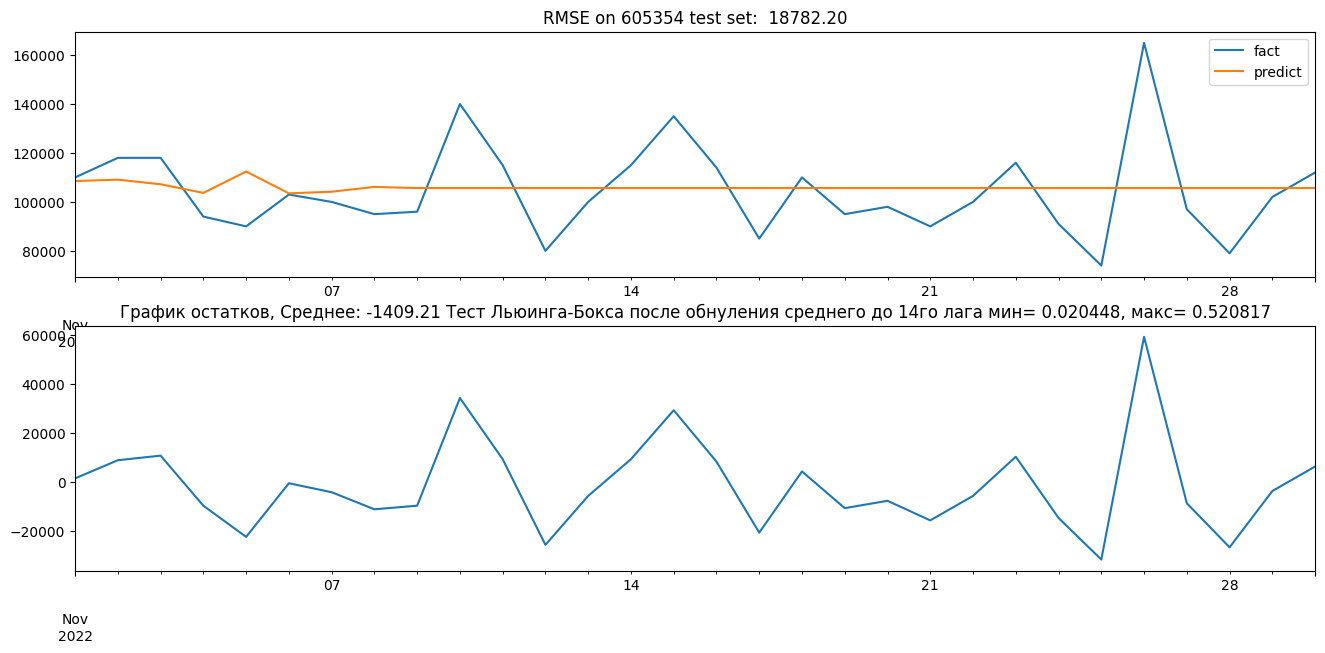

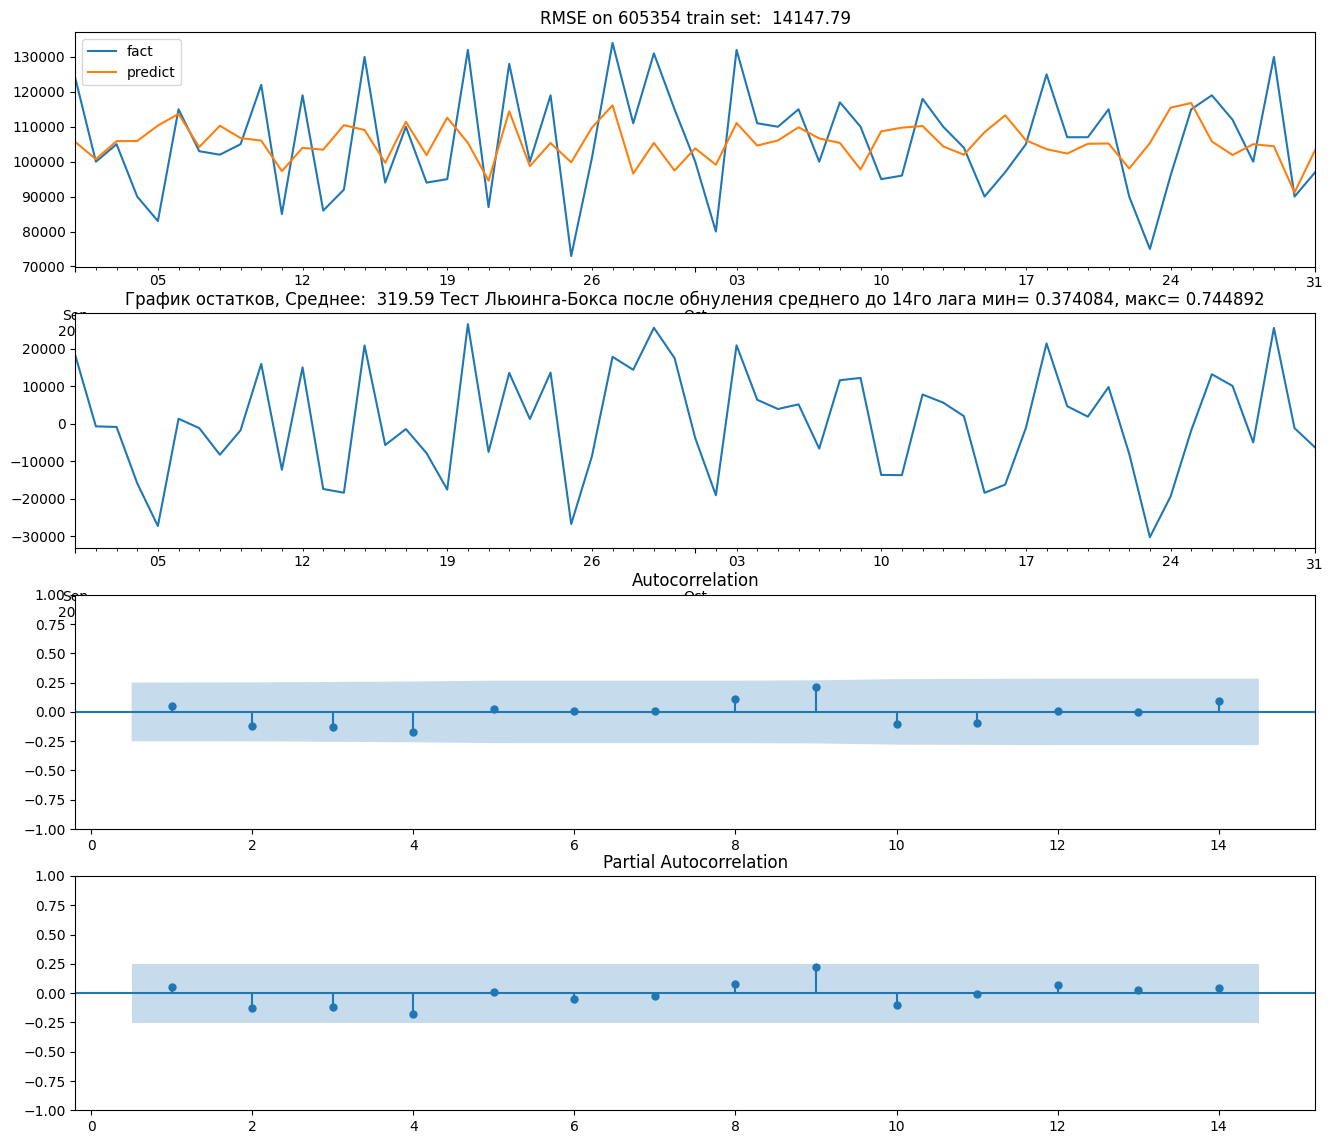

In [45]:
#model_auto_fitted = pm.auto_arima(data[605354].copy()[:-30], seasonal=True, m=7)
#tid_modeling = 605354
# models[tid_modeling] = {}
models_h[tid_modeling]['arima_auto'] = show_predictions_autoarima(data[tid_modeling].copy(), season_order=7, show_train=True)

In [46]:
models_h[tid_modeling]['arima_auto'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   61
Model:             SARIMAX(0, 0, 1)x(0, 0, 1, 7)   Log Likelihood                -669.764
Date:                           Thu, 25 May 2023   AIC                           1347.529
Time:                                   04:24:01   BIC                           1355.972
Sample:                               09-01-2022   HQIC                          1350.838
                                    - 10-31-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.057e+05   1850.051     57.114      0.000    1.02e+05    1.09e+05
ma.L1         -0.2934      0.144     -2.044      0.041      -0.575      -0.012
ma.S.L7        0.2491      0.156      1.602      0.109      -0.056       0.554
sigma2      2.241e+08      0.002    1.3e+11      0.000    2.24e+08    2.24e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 1.53
Prob(Q):                              0.68   Prob(JB):                         0.47
Heteroskedasticity (H):               0.88   Skew:                            -0.07
Prob(H) (two-sided):                  0.78   Kurtosis:                         2.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.05e+28. Standard errors may be unstable.
"""

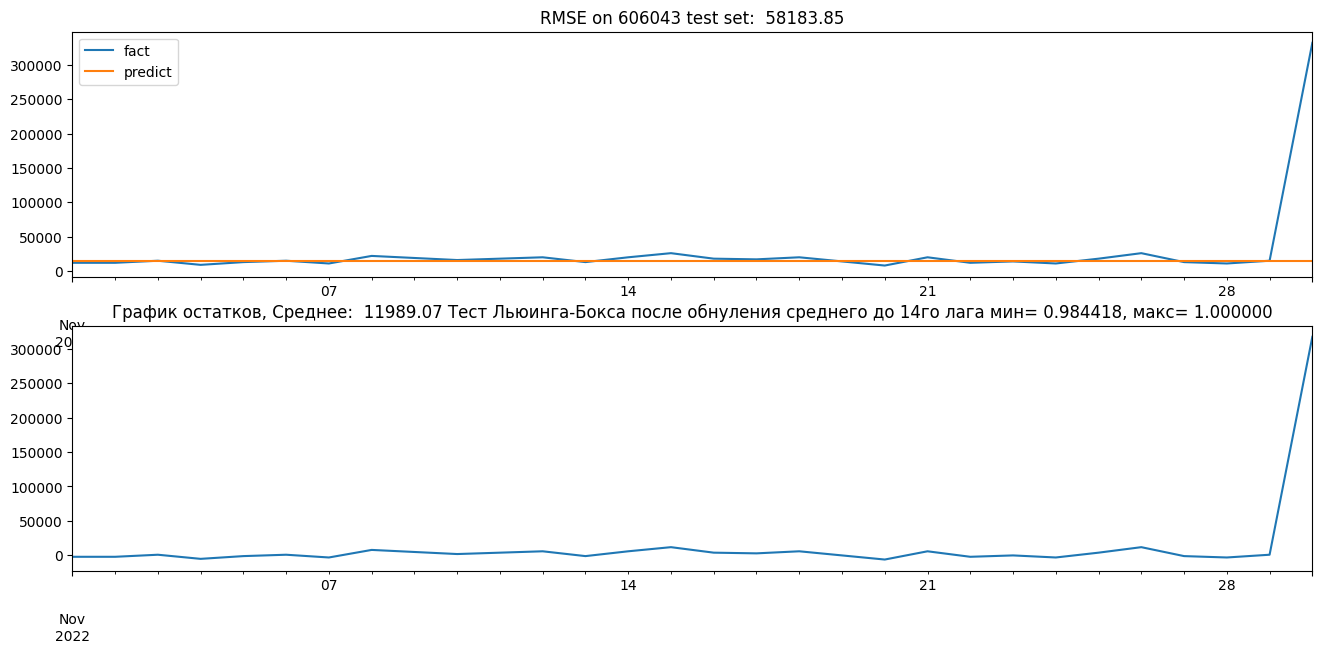

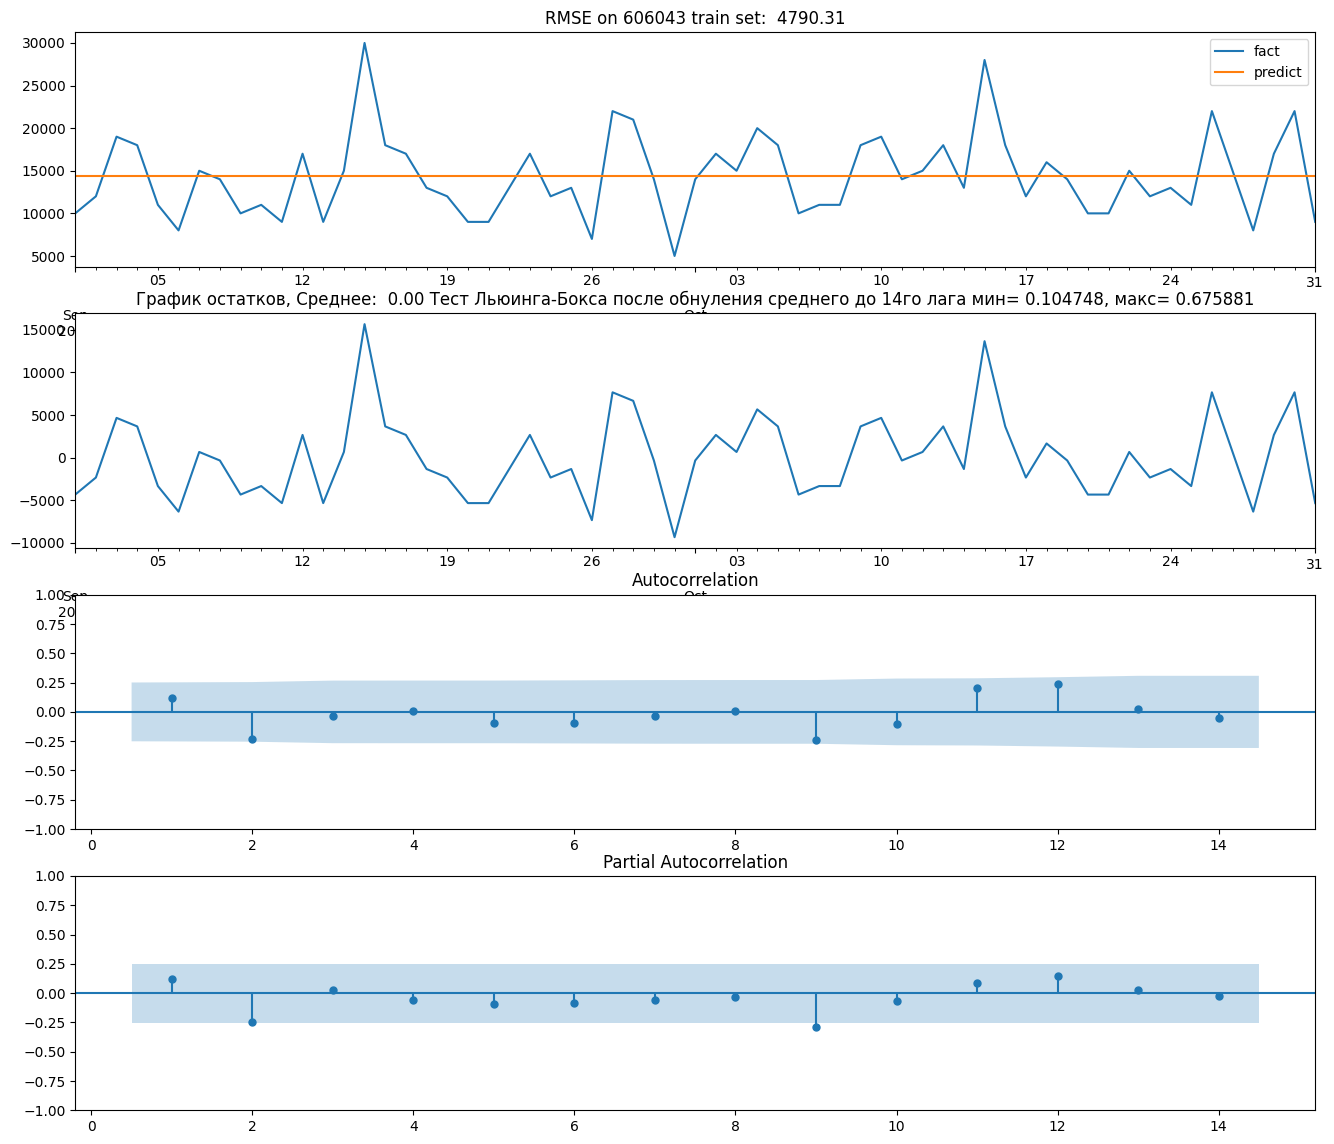

In [47]:
tid_modeling = tid_super_abnormal[0]
models_h[tid_modeling] = {}
models_h[tid_modeling]['arima_auto'] = show_predictions_autoarima(data[tid_modeling].copy(), season_order=7, show_train=True)

In [48]:
models_h[tid_modeling]['arima_auto'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   61
Model:                        SARIMAX   Log Likelihood                -603.491
Date:                Thu, 25 May 2023   AIC                           1210.981
Time:                        04:26:05   BIC                           1215.203
Sample:                    09-01-2022   HQIC                          1212.636
                         - 10-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.434e+04    699.087     20.519      0.000     1.3e+04    1.57e+04
sigma2      2.295e+07   3.82e+06      6.006      0.000    1.55e+07    3.04e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.90   Jarque-Bera (JB):                10.12
Prob(Q):                              0.34   Prob(JB):                         0.01
Heteroskedasticity (H):               0.93   Skew:                             0.84
Prob(H) (two-sided):                  0.88   Kurtosis:                         4.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# 4. Production.

In [49]:
#models_dict = {}
#models_results = pd.DataFrame()

file_name_4_results = 'models_rmse_train_valid'
AUTO_CV = 'arima_auto'
HANDY_CV = 'arima_h'

In [76]:
def models_dump(models):
    path = disk_name + project_name + path_2_results
    for name in models:
        with open(f'{path}/{name}.pkl', 'wb') as fl:
            pickle.dump(models[name], fl)
    return {}

def models_read(tids_lst_of_models=None):  
    models = {}
    path = disk_name + project_name + path_2_results
    files_lst = [fn for fn in os.listdir(path) if 'None.pkl' in fn]  
    if tids_lst_of_models is not None: 
        files_lst = [fn for fn in files_lst if int(fn.split('_')[0]) in tids_lst_of_models]
    for filename in files_lst: 
        with open(f'{path}/{filename}', 'rb') as pkl:
            models[int(filename.split('.')[0].split('_')[0])] = pickle.load(pkl)
    return models


def models_results_dump(results, fn=file_name_4_results, suff='_last'):
    #results.to_csv(fn)
    #print(fn)
    return csv_dump(df, fn=fn, suff=suff)

def models_read(tids_lst_of_models=None):  
    models = {}
    path = disk_name + project_name + path_2_results
    files_lst = [fn for fn in os.listdir(path) if 'None.pkl' in fn]  
    if tids_lst_of_models is not None: 
        files_lst = [fn for fn in files_lst if int(fn.split('_')[0]) in tids_lst_of_models]
    for filename in files_lst: 
        with open(f'{path}/{filename}', 'rb') as pkl:
            models[int(filename.split('.')[0].split('_')[0])] = pickle.load(pkl)
    return models

def test_a_model(model, tid, df=data, days_for_test=D_TEST): 
    ts_train = df[tid][:-days_for_test].copy()
    ts_test = df[tid][-days_for_test:].copy()
    prediction = model.predict(n_periods=days_for_test)
    predict_in_sample = model.predict_in_sample()
    rmse_test =  mean_squared_error(ts_test,  prediction) ** 0.5
    rmse_train = mean_squared_error(ts_train, predict_in_sample) ** 0.5
    return rmse_test, rmse_train

def add_result_2_df(index_for_results, tid, model_name, rmse_test, rmse_train, results_df=None):
    if results_df is None:
        results_df = pd.DataFrame()
    results_df.loc[index_for_results, 'tid'] = f'{tid}'
    results_df.loc[index_for_results, 'model_name'] = model_name
    results_df.loc[index_for_results, 'rmse_test'] = round(rmse_test)
    results_df.loc[index_for_results, 'rmse_train'] = round(rmse_train)
    return results_df

def models_test(models, df=data, days_for_test=D_TEST):
    results = pd.DataFrame()
    for tid in models:
        #tid = int(model_name.split('_')[0])
        ts_train = df[tid][:-days_for_test]#.copy()
        ts_test = df[tid][-days_for_test:]#.copy()
        curr_date = datetime.today().strftime('%Y-%m-%d')
        index_for_results = f'{tid} tid, {days_for_test} days for test. Testing on {curr_date}'
        rmse_test, rmse_train = test_a_model(models[tid], tid, df=df, days_for_test=days_for_test)
        add_result_2_df(results_df=results, index_for_results=index_for_results, tid=tid, model_name=f'{tid}_auto_arima', rmse_test=rmse_test, rmse_train=rmse_train)
    return results

In [51]:
def fit_auto_arima(tid, df=data, days_for_test=D_TEST, season_order=7, rank=None, **kwargs):
    ts_train = df[tid][:-days_for_test].copy()
    ts_test = df[tid][-days_for_test:].copy()
    model_fitted = pm.auto_arima(ts_train, seasonal=True, m=season_order, d=rank, **kwargs)
    model_name = f'{tid}_{AUTO_CV}_rank_{rank}'
    index_for_results = f'{tid} tid, {days_for_test} days for test'
    return model_fitted, model_name, index_for_results

def fit_auto_arima_list(tid_lst, df=data, days_for_test=D_TEST, season_order=7, rank=None, **kwargs):
    models = {}
    models_results = pd.DataFrame()
    for tid in tid_lst:
        model_fitted, model_name, index_for_results = fit_auto_arima(tid, df=df, days_for_test=days_for_test, season_order=season_order, rank=rank)
        models[model_name] = model_fitted
        rmse_test, rmse_train = test_a_model(model_fitted, tid, df=df, days_for_test=days_for_test)
        index_for_results = f'{index_for_results}. After CV fitting'
        add_result_2_df(results_df=models_results, index_for_results=index_for_results, tid=tid, model_name=model_name, rmse_test=rmse_test, rmse_train=rmse_train)
    return models, models_results

def fit_auto_arima_list_dump(tid_lst, batch_size=50, first_tid=0, df=data, days_for_test=D_TEST, season_order=7, rank=None, **kwargs):
    models_qnt = len(tid_lst) - first_tid
    steps = models_qnt // batch_size + 1
    for step in range(steps):
        print(f'Start {step}s step. Batch size = {batch_size}.')
        start_slice = first_tid + step * batch_size
        end_slice = start_slice + batch_size
        models_dict, models_results = fit_auto_arima_list(tid_lst[start_slice:end_slice], df=df, days_for_test=days_for_test, season_order=season_order, rank=rank)    
        models_dict = models_dump(models_dict)
        models_results = models_results_dump(models_results, suff=f'ttl{len(tid_lst)}_start{start_slice}_end{end_slice}')
        print(f'Save models from {start_slice} till {end_slice} from list')

In [52]:
# Здесь запускаем авто ариму для большого списка с сохранением результатов
# fit_auto_arima_list_dump(stationary[2], batch_size=10, rank=None)



#4.1 Проверка моделей на адекватность. 

In [53]:
all_models = models_read()

In [ ]:
def get_prediction(models_dict, tid, date, df=data, days_for_test=D_TEST):
    model_fitted = models_dict[get_model_name(tid, models_dict)]
    #ts_train = df[tid][:-days_for_test].copy()
    #ts_test = df[tid][-days_for_test:].copy()
    prediction = pd.concat([model_fitted.predict_in_sample(), model_fitted.predict(n_periods=days_for_test)])
    return df.loc[date, tid], prediction.loc[date]
  
get_prediction(models, 605354, '2022-11-30')

In [54]:
tids_fitted = set(all_models)
tids_not_fitted = list(set(tid_df.index) - tids_fitted)


In [55]:
tids_not_fitted

[]

In [71]:
all_results = models_test(all_models)

In [72]:
all_results.sort_values(by='rmse_test', ascending=False).head(10)

,tid,model_name,rmse_test,rmse_train
"606531 tid, 30 days for test. Testing on 2023-05-24",606531,606531_auto_arima,228239.0,97360.0
"616681 tid, 30 days for test. Testing on 2023-05-24",616681,616681_auto_arima,227252.0,168865.0
"605329 tid, 30 days for test. Testing on 2023-05-24",605329,605329_auto_arima,210762.0,182895.0
"676981 tid, 30 days for test. Testing on 2023-05-24",676981,676981_auto_arima,210469.0,379081.0
"669424 tid, 30 days for test. Testing on 2023-05-24",669424,669424_auto_arima,196759.0,30501.0
"629806 tid, 30 days for test. Testing on 2023-05-24",629806,629806_auto_arima,185633.0,44351.0
"635576 tid, 30 days for test. Testing on 2023-05-24",635576,635576_auto_arima,158603.0,22308.0
"636402 tid, 30 days for test. Testing on 2023-05-24",636402,636402_auto_arima,134291.0,61473.0
"677547 tid, 30 days for test. Testing on 2023-05-24",677547,677547_auto_arima,129868.0,42522.0
"619604 tid, 30 days for test. Testing on 2023-05-24",619604,619604_auto_arima,123923.0,55918.0


## Разобрать!

### **Важное замечание**
Хотя ниже просто тесты вновь создаваемых функций, результаты (графики и ошибки прогнозов) ниже важны и по другой причине! Выведены результаты построения модели через CV подбор параметров для SARIMAX модели одного из самых показательных терминалов (606043) в смысле выбросов 



In [ ]:
# Проверяем что не изменилась работа при авто ариме для одного тида
tid_s = 605354
#result = fit_auto_arima(tid_s)
show_predictions_autoarima_fitted(result[0], data[tid_s], show_train=True)

# Проверяем что не изменилась работа при авто ариме для списка тидов
tid_lst_check = [605354, 606043]
#models_check, models_results_check = fit_auto_arima_list(tid_lst_check)
tid_s = tid_lst_check[0]
show_predictions_autoarima_fitted(models_check[get_model_name(tid_s, models_check)], data[tid_s], show_train=True)

models_results_check
